# <center> Genetic Algorithm </center>

## Intialization

In [1]:
%reset -f

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc

from more_itertools import sort_together
from numpy import sin, cos, exp, pi

## Classes, Functions and Definitions

In [3]:
num_population = 80
example = 3

In [4]:
if example==1:    # Paraboloid
    niter = 30
    lim_init = [[-1, 1], [-1, 1]]
    target = [0, 0]
    objective_function = lambda x: 0.7*x[0]**2 + x[1]**2
elif example==2:    #  Torus
    niter = 70
    TwoPi = 2*pi
    lim_init = [[0, 0.25*TwoPi], [0, 0.25*TwoPi]]
    target = [3*pi/2, 2*pi]
    objective_function = lambda x: (x[0]%TwoPi- target[0])**2 + (x[1]%TwoPi - target[1])**2
elif example==3:    #  Sea-Shell
    niter = 100
    TwoPi = 2*pi
    lim_init = [[0, 2*pi], [0, 2*pi]]
    target = [5.5*pi, 2*pi]
    objective_function = lambda x: (x[0]- target[0])**2 + (x[1]%TwoPi - target[1])**2
elif example==4:    #  Bumpy-Sphere
    niter = 70
    TwoPi = 2*pi
    lim_init = [[0, 0.15*TwoPi], [0, 0.15*TwoPi]]
    target = [0.83*pi, pi]
    objective_function = lambda x: (x[0]%TwoPi- target[0])**2 + (x[1]%TwoPi - target[1])**2
elif example==5:    #  Klein-Bottle
    niter = 50
    TwoPi = 2*pi
    lim_init = [[0, 0.25*pi], [0, 0.25*pi]]
    target = [2*pi, 2*pi]
    objective_function = lambda x: (x[0]- target[0])**2 + (x[1] - target[1])**2
    

In [5]:
class Individual:
    """ Indivudual gen carriers for the genetic algorithm """
    def __init__(self, lim_init=lim_init):
        self.x = np.array([np.random.uniform(lim_init[0][0], lim_init[0][1], 1)[0], 
                           np.random.uniform(lim_init[1][0], lim_init[1][1], 1)[0]])
        self.selected = False
        self.fitness = 0
    
    def calculate_fitness(self, objective_function):
        self.fitness = 1.0 - objective_function(self.x)
    
    def clear(self):
        self.selected = False
        
    def print_state(self):
        print(f'x = {self.x}, selected={self.selected}')

In [6]:
def select(population: list, frac_top=0.8, frac_bottom=0.1) -> list:
    """ frac_top: fraction of the population selected for breeding for having good fit
        frac_bottom: : fraction of the population selected for breeding for diversity
                       This population is selected randomly for breeding
    """
    assert  0.0 <= frac_top <= 1.0, 'frac must be a fraction from 0.0 to 1.0'
    assert  0.0 <= frac_top <= 1.0, 'frac must be a fraction from 0.0 to 1.0'
    assert  0.0 <= frac_top+frac_bottom <= 1.0, 'frac_top+frac_bottom connot be larger than 1.0'
    # calculate fitness
    for i, _ in  enumerate(population):
        population[i].calculate_fitness(objective_function)
    # sort according to increasing fitness
    population_fitness = [ pop.fitness for pop in population ]
    population = sort_together([population_fitness, population])[1]
    # select the top frac elements for breeding
    cutoff_nr_top = int(frac_top*len(population))
    for i, _ in  enumerate(population):
        if i<= cutoff_nr_top: continue
        population[i].selected = True
    # select also a random sample of the other elements for breeding (genetic diversity)
    cutoff_nr_bottom = int(frac_bottom*len(population))
    for i in  range(cutoff_nr_bottom):
        random_index = np.random.randint(0, cutoff_nr_top-1)
        population[random_index].selected = True
    return population

In [7]:
def cross_over(pop_old: list) -> list:
    pop_new = []
    population_nr = 0
    while population_nr < len(pop_old):
        i_random = np.random.randint(0, len(pop_old))
        j_random = np.random.randint(0, len(pop_old))
        if (pop_old[i_random].selected is False) or (pop_old[j_random].selected is False): continue
        child = breed(pop_old[i_random], pop_old[j_random])
        pop_new.append(child)
        population_nr += 1
    return pop_new

In [8]:
def breed(parent1: Individual, parent2: Individual) -> Individual:
        child = Individual()
        child.x[0] = np.random.choice([parent1.x[0], parent2.x[0]])
        child.x[1] = np.random.choice([parent1.x[1], parent2.x[1]])
        return child

In [9]:
def mutate(ind: Individual, mutation_proba=0.75, mutation_strenght=0.31) -> Individual:
    if np.random.rand()>=mutation_proba: 
        for i, _ in enumerate(ind.x):
            ind.x[i] = ind.x[i] + np.random.uniform(-mutation_strenght, mutation_strenght)
    return ind 

## Run the Experiment

In [10]:
# initialize population
pop_new = [Individual() for i in range(num_population)]
# initialize the snapshots (for the movie)
snapshot = []

In [11]:
# Run iterations
for t in range(niter):
    # print iteration
#     print('iter = ', t)
    pop_old = pop_new
    # selection
    pop_old = select(pop_old)
    # breeding (done by selecting pais at random)
    pop_new = cross_over(pop_old)
    # mutation
    for i, _ in  enumerate(pop_new):
        pop_new[i] = mutate(pop_new[i])
    # clear state
    for i, _ in  enumerate(pop_new):
        pop_new[i].clear()
    # save snapshot coordinates
    snapshot.append([pop.x for pop in pop_new])

## Plot Animated Results 

In [12]:
def paraboloid(X, Y):
    Z = X**2 + Y**2
    return X, Y, Z

In [13]:
def torus(u, v, r=0.5, R=1.):
    X = (R + r * cos(v)) * cos(u)
    Y = (R + r * cos(v)) * sin(u)
    Z = r * np.sin(v)
    return X, Y, Z

In [14]:
def seashell(u, v):
    X = 2*(1-exp(u/(6*pi)))*cos(u)*cos(v/2)**2;
    Y = 2*(-1+exp(u/(6*pi)))*sin(u)*cos(v/2)**2;
    Z = 1-exp(u/(3*pi))-sin(v)+exp(u/(6*pi))*sin(v);
    return X, Y, Z

In [15]:
def bumpy_sphere(u, v):
    R = 1 + 0.1*sin(9*u)*cos(9*v)
    X = R*cos(u)*sin(v)
    Y = R*sin(u)*sin(v)
    Z = R*cos(v)
    return X, Y, Z

In [16]:
def klein_bottle(u, v):
    X = -(2/15)*cos(u)*(3*cos(v)-30*sin(u)+90*cos(u)**4*sin(u)- \
        60*cos(u)**6*sin(u)+5*cos(u)*cos(v)*sin(u));
    Y = -(1/15)*sin(u)*(3*cos(v)-3*cos(u)**2*cos(v)-48*cos(u)**4*cos(v)+ \
        48*cos(u)**6*cos(v)-60*sin(u)+5*cos(u)*cos(v)*sin(u) 
        -5*cos(u)**3*cos(v)*sin(u) -80*cos(u)**5*cos(v)*sin(u)+ \
        80*cos(u)**7*cos(v)*sin(u));
    Z = (2/15)*(3+5*cos(u)*sin(u))*sin(v);
    return X, Y, Z

In [17]:
def manifold_3D(example, u, v):
    if example==1:
        return paraboloid(u, v)
    elif example==2:
        return torus(u, v)
    elif example==3:
        return seashell(u, v)
    elif example==4:
        return bumpy_sphere(u, v)
    elif example==5:
        return klein_bottle(u, v)

In [18]:
def set_axis(ax, example):
    if example==1:
        x_min, x_max, y_min, y_max, z_min, z_max = (-1,1,-1,1,-1,1)
    elif example==2:
        x_min, x_max, y_min, y_max, z_min, z_max = (-1,1,-1,1,-1,1)
    elif example==3:
        x_min, x_max, y_min, y_max, z_min, z_max = (-2,2,-2,2,-8,0)
    elif example==4:
        x_min, x_max, y_min, y_max, z_min, z_max = (-1,1,-1,1,-1,1)
    elif example==5:
        x_min, x_max, y_min, y_max, z_min, z_max = (-2,2,0,3,-2,2)
    ax.set_xlim3d(x_min, x_max); ax.set_ylim3d(y_min, y_max); ax.set_zlim3d(z_min, z_max)

In [19]:
def paramter_space_coverage(example):
    if example==1: return np.linspace(-1, 1, 32)
    elif example==2: return np.linspace(0, 2*TwoPi, 132)
    elif example==3: return np.linspace(0, 3.5*TwoPi, 132)
    elif example==4: return np.linspace(0, TwoPi, 132)
    elif example==5: return np.linspace(0, TwoPi, 132)

### Population Migration towards the target

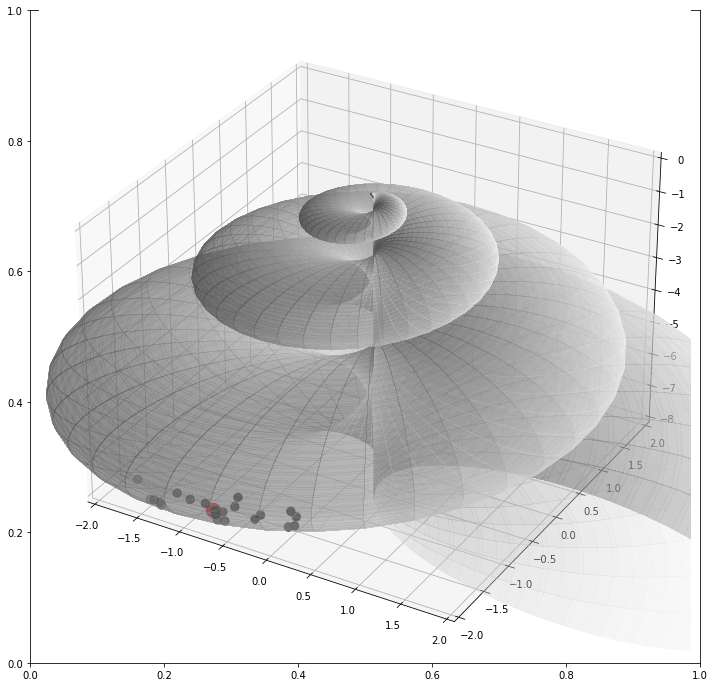

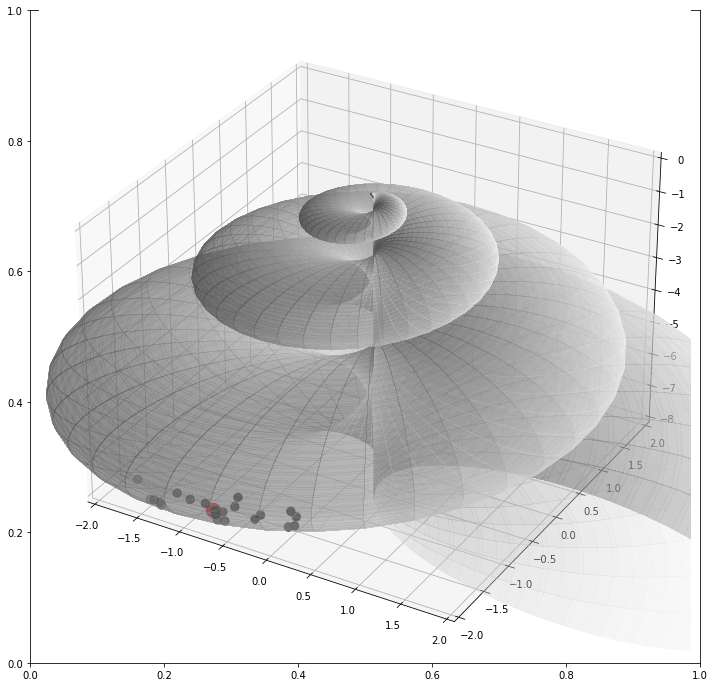

In [20]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation
import numpy as np
from IPython.display import display, clear_output

# define figure
fig, ax = plt.subplots(figsize=(12,12))
ax = fig.gca(projection = '3d')
set_axis(ax, example)

# define parametric surface
parameter = paramter_space_coverage(example)
u, v = np.meshgrid(parameter, parameter)
X, Y, Z = manifold_3D(example, u, v)

for it in range(niter):
    ax.clear(); set_axis(ax, example)
    # generate population & target data
    u = np.array([ pop_x[0] for pop_x in  snapshot[it]])
    v = np.array([ pop_x[1] for pop_x in  snapshot[it]])
    # map population intrinsecal coordinates to 3D embedding coordinates 
    x, y, z = manifold_3D(example, u, v)
    tx, ty, tz = manifold_3D(example, target[0], target[1])
    # plot 3D
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, color='w', linewidth=0, antialiased=False, alpha=0.15)
    ax.scatter(xs=x, ys=y, zs=z, s=70, c='k')
    ax.scatter(xs=tx, ys=ty, zs=tz, s=200, c='r')
    # clear when the next frame is ready
    clear_output(wait=True)
    # display current
    display(fig)

### Population Traces towards the goal

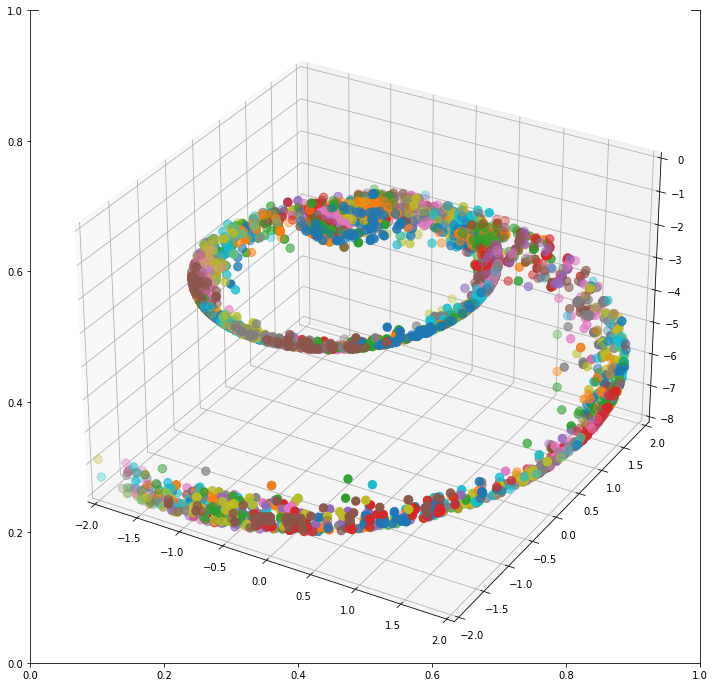

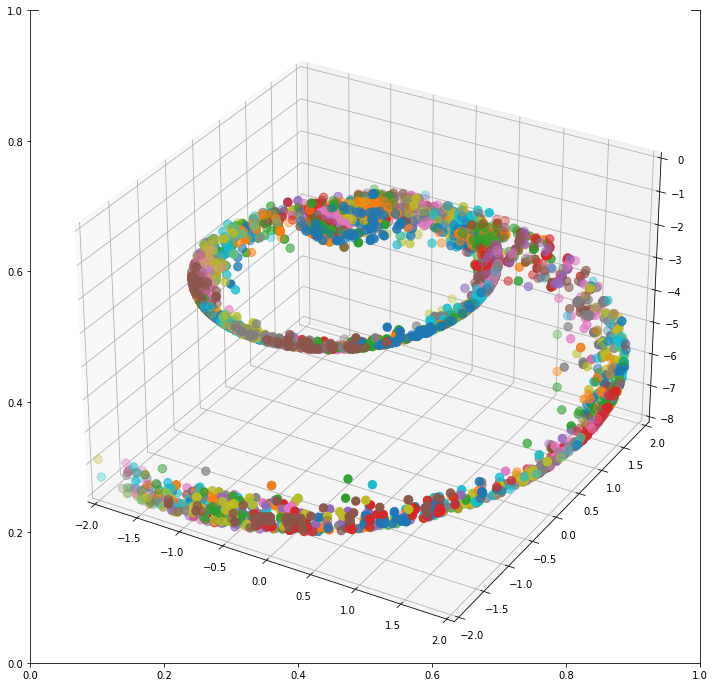

In [21]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation
import numpy as np
from IPython.display import display, clear_output

# define figure
fig, ax = plt.subplots(figsize=(12,12))
ax = fig.gca(projection = '3d')
set_axis(ax, example)

# define parametric surface
parameter = paramter_space_coverage(example)
u, v = np.meshgrid(parameter, parameter)
X, Y, Z = manifold_3D(example, u, v)

for it in range(niter):
#     ax.clear(); set_axis(ax, example)
    # generate population & target data
    u = np.array([ pop_x[0] for pop_x in  snapshot[it]])
    v = np.array([ pop_x[1] for pop_x in  snapshot[it]])
    # map population intrinsecal coordinates to 3D embedding coordinates 
    x, y, z = manifold_3D(example, u, v)
    tx, ty, tz = manifold_3D(example, target[0], target[1])
    # plot 3D
#     ax.plot_surface(X, Y, Z, color='w', rstride = 1, cstride = 1, alpha=0.15)
    ax.scatter(xs=x, ys=y, zs=z, s=70)
    ax.scatter(xs=tx, ys=ty, zs=tz, s=170, c='r')
    # clear when the next frame is ready
    clear_output(wait=True)
    # display current
    display(fig)

# Extract the best result

In [22]:
# Calculate fitness
for i, _ in  enumerate(pop_new):
    pop_new[i].calculate_fitness(objective_function)
population_fitness = [ pop.fitness for pop in pop_new ]
# Extract best fitness
index_best = np.argmax(population_fitness)
print('best solution coordinates:')
pop_new[index_best].print_state()
print('best solution fitness (0-worst, 1-best):')
print('x_fitness = ', pop_new[index_best].fitness)

best solution coordinates:
x = [17.27172344  6.28311831], selected=False
best solution fitness (0-worst, 1-best):
x_fitness =  0.9999504880938183
